## Modules used in project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

## Development of MATH function

In [2]:
#test file location
maf_file = r'C:\Users\maytu\Documents\tables6.csv'
test = pd.read_csv(maf_file)

In [3]:
def MATH_score(maf_df,filt=False, min_depth=0, min_loci=2):
    """Calculates MATH scores for each unique tumor sample within a .maf data file (GDC MAF Format v.1.0.0). 
    Must import .maf file to Pandas DataFrame first. Filter parameters can be turned on by 'filt=True'. Filters inlcude 
    minimum depth (min_depth) for all loci and minimum loci per sample (min_loci). 
    Samples that do not meet criteria will be dropped."""
    
    #retrieves columns of maf dataframe to check for appropriate data.
    columns = list(maf_df.columns)
          
    #if no 'tumor_f', search for 't_ref_count' and 't_alt_count'
    if 't_ref_count' and 't_alt_count' in columns:
        #if  present, sort only tumor identifer ('Tumor_Sample_Barcode'), 't_ref_count' and 't_alt_count' cols
        maf_df = maf_df.loc[:,['Tumor_Sample_Barcode','t_ref_count','t_alt_count']]
        #converts placeholders to NaN values
        maf_df = maf_df.replace(['-''--','---','NA','None'],np.nan)
        #drops rows with missing values from 'Tumor_Sample_Barcode', 't_ref_count', or 't_alt_count'
        maf_df = maf_df.dropna()
        
    #if no 'tumor_f' or 't_ref_count' and 't_alt_count', raise IndexError
    else:
        raise IndexError("missing 'tumor_f' and 't_ref_count' and/or 't_alt_count'")
    
    
    #tumor reference (unmutated) allele count and alternative (mutated) allele counts found during NGS
    ref = 't_ref_count'
    alt = 't_alt_count'
        
    #confirms 't_ref_count' and 't_alt_count' are numeric
    maf_df = maf_df.astype({'t_ref_count':'float64','t_alt_count':'float64'})
    #computes mutant allele freq ('tumor_f') from ref and alt allele counts and store as new col in df
    maf_df['tumor_f'] = (maf_df[alt]/(maf_df[alt]+maf_df[ref]))
    #compute depth (number of reads) at each loci
    maf_df['depth'] = (maf_df[alt]+maf_df[ref])
    
    #sets index for working dataframe
    maf_df = maf_df.set_index('Tumor_Sample_Barcode')
    
    #only for it active filter parameters
    if filt:
        #drops any reads below set 'min_depth' filter parameter
        maf_depth_drop = maf_df[maf_df['depth']>=min_depth]
        #lists of any samples dropped due to no remaining loci
        depth_list = set(list(maf_df.index)).difference(list(maf_depth_drop.index))
        #counts number of loci for each samples
        maf_count = maf_depth_drop.groupby('Tumor_Sample_Barcode').count()
        #lists loci samples with less loci remaining that 'min_loci' parameter
        loci_list = maf_count.loc[maf_count['tumor_f']<min_loci,:].index
        #drops loci that do not meet 'min_loci' parameter
        maf_df = maf_depth_drop.drop(index = loci_list)
        #prints any samples dropped due to filter parameters
        if len(list(depth_list))>=1:
            print ('Failed min_depth:', list(depth_list))
        if len(list(loci_list))>=1:      
            print('Failed min_loci:', list(loci_list))
    
    #computes median of MAF for each tumor sample 
    maf_median = maf_df.groupby("Tumor_Sample_Barcode").median()
    
    #dicts for MAD and MATH values for each tumor sample
    MAD = {}
    MATH = {}
    
    #computes MAD score for each tumor.
    for i in maf_median.index:
        c = 1.4826
        #'i' is the current tumor sample; 'k' is mutant allele freq of current tumor sample at a specific loci
        k = maf_df.loc[i,'tumor_f'].abs()
        #'n' is the MAD of the current tumor sample; MAD = median(|k-median|) 
        n = c*((k-maf_median.loc[i,'tumor_f']).abs().median())
        MAD[i] = n
    #computes MATH score for each tumor
    for l in MAD:
        m = (100*MAD[l])/maf_median.loc[l,'tumor_f']
        MATH[l] = m
    #outputs a dict with tumor ID and MATH score
    return(MATH)

## Testing MATH function

### Processing data

In [4]:
#computes number of mutations for each tumor and reformatting DataFrame
mut_test = test[['Tumor_Sample_Barcode','Genome_Change']].rename(columns={'Genome_Change':'Mutations'}).groupby('Tumor_Sample_Barcode').count()
#converts mutations to log2 scale to better fit graph
mut_test['Mutations_log'] = np.log2(mut_test['Mutations'])

### All loci

In [5]:
#test run of data that has reference MATH scores in literature
math_0 = MATH_score(test)

In [6]:
#converts MATH_score output to DataFrame
math_0 = pd.DataFrame(data = math_0, index = [0]).melt()
#labels columns of DataFrame to match other data sets
math_0 = math_0.rename(columns={'variable':'Tumor_Sample_Barcode', 'value':'MATH'}).set_index(['Tumor_Sample_Barcode'])

In [7]:
#merges mutation and MATH scores from test dataset into single DataFrame
merge_0 = pd.merge(mut_test,math_0, right_index=True, left_index=True)
merge_0

,Mutations,Mutations_log,MATH
Tumor_Sample_Barcode,,,
HN_0-046-Tumor,104,6.700440,30.849694
HN_0-064-Tumor,24,4.584963,20.545523
HN_00076-Tumor,124,6.954196,25.506886
HN_00122-Tumor,66,6.044394,32.644404
HN_00190-Tumor,230,7.845490,35.168648
...,...,...,...
HN_63080-Tumor,300,8.228819,25.277762
HN_63081-Tumor,109,6.768184,55.212434
HN_63095-Tumor,25,4.643856,41.296164


### Loci >99 reads

In [8]:
#test run of data that has reference MATH scores in literature
math_100 = MATH_score(test,filt=True, min_depth=100)

In [9]:
#converts MATH_score output to DataFrame
math_100 = pd.DataFrame(data = math_100, index = [0]).melt()
#labels columns of DataFrame to match other data sets
math_100= math_100.rename(columns={'variable':'Tumor_Sample_Barcode', 'value':'MATH'}).set_index(['Tumor_Sample_Barcode'])

In [10]:
#merges mutation and MATH scores from test dataset into single DataFrame
merge_100 = pd.merge(mut_test,math_100, right_index=True, left_index=True)
merge_100

,Mutations,Mutations_log,MATH
Tumor_Sample_Barcode,,,
HN_0-046-Tumor,104,6.700440,30.831646
HN_0-064-Tumor,24,4.584963,15.558665
HN_00076-Tumor,124,6.954196,24.763285
HN_00122-Tumor,66,6.044394,29.027088
HN_00190-Tumor,230,7.845490,30.925643
...,...,...,...
HN_63080-Tumor,300,8.228819,22.572672
HN_63081-Tumor,109,6.768184,40.464259
HN_63095-Tumor,25,4.643856,4.801943


### Testing 

In [11]:
#select samples and values available in literature. Identical to literature values.
print('All loci:','\n',math_0.loc[['HN_62469-Tumor','HN_62601-Tumor','HN_62417-Tumor'],:])

All loci: 
                            MATH
Tumor_Sample_Barcode           
HN_62469-Tumor        19.287931
HN_62601-Tumor        33.995298
HN_62417-Tumor        53.510636


In [12]:
#select samples and values available in literature but with 'min_depth' set to 100. No longer identical to 
#literature values.
print('Depth>99','\n',math_100.loc[['HN_62469-Tumor','HN_62601-Tumor','HN_62417-Tumor'],:])

Depth>99 
                            MATH
Tumor_Sample_Barcode           
HN_62469-Tumor        12.468427
HN_62601-Tumor        30.333380
HN_62417-Tumor        43.588000


In [13]:
#Kendall test betw MATH and Mutations. pvalue ~0.21 from literature.
stats.kendalltau(mut_test['Mutations'],math_0['MATH'])

SignificanceResult(statistic=0.09465510795168827, pvalue=0.2339613242677785)

In [14]:
#Kendall test betw MATH and Mutations when 'min_depth' set to 100. pvalue ~0.21 from literature.
stats.kendalltau(merge_100['Mutations'],merge_100['MATH'])

SignificanceResult(statistic=0.08500399890563379, pvalue=0.28513228121654166)

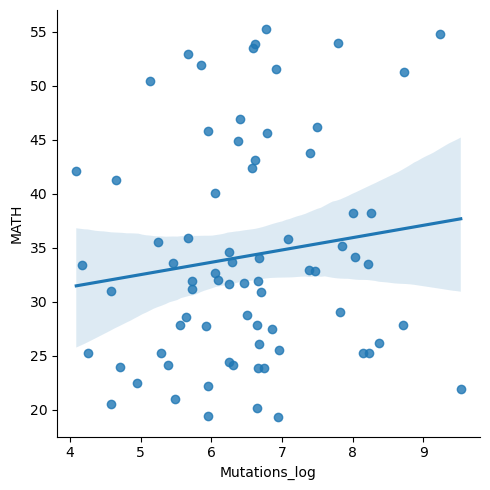

In [15]:
#scatterplot of mutations vs MATH score. similar pattern to literature
sns.lmplot(data=merge_0,x='Mutations_log',y='MATH')

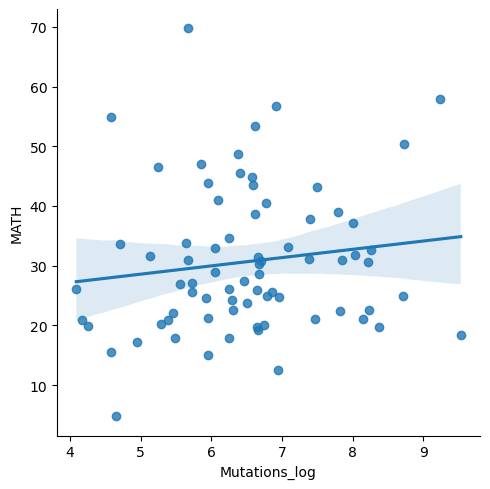

In [16]:
#scatterplot of mutations vs MATH score when 'min_depth' set to 100.
sns.lmplot(data=merge_100,x='Mutations_log',y='MATH')

## Applying MATH function to PRAD dataset

In [17]:
def MATH_gdc(directory, filt=False, min_depth=0):
    
    """computes MATH score from a locally stored folder containing .maf files downloaded from the GDC website. 
    input is the path to the folder."""
    
    #obtains list of files from folder in directory
    dirlist = os.listdir(directory)
    
    #dictionary to store tumor IDs and MATH scores
    math={}
    
    #computes math score for each file in folder
    for file in dirlist:
        try:
            #comment rows 1-8 are discarded
            df=pd.read_csv((directory+ '/'+ file),sep ='\t',lineterminator='\n', header = 7)
            math.update(MATH_score(df,filt=filt, min_depth=min_depth))
        #skips files that cannot be read.
        except:
            pass
    
    #number of files and number of files read
    files=len(dirlist)
    reads=len(math)
    
    #prints the number of files that could be read compared to total files in folder.
    print(reads,'/',files,'processed')
    
    #returns filled dictionary with tumor IDs and MATH scores.
    return(math)

In [18]:
#absolute path of folder containing all PRAD .maf data files from the GDC.
folder = r'C:\Users\maytu\Documents\PRAD_TCGA_maf'
#computes MATH score of PRAD dataset.
math_PRAD_dict = MATH_gdc(folder)

C:\Users\maytu\AppData\Local\Temp\ipykernel_4324\4203069644.py:16: DtypeWarning: Columns (74,112,114,120,132) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv((directory+ '/'+ file),sep ='\t',lineterminator='\n', header = 7)


491 / 501 processed


In [19]:
#converts dict to DataFrame
math_PRAD_df = pd.DataFrame(math_PRAD_dict, index=[0]).melt()
#cuts to Tumor ID to first 12 characters to match tumor ID in clinical dataset
math_PRAD_df = math_PRAD_df.assign(variable = lambda x:math_PRAD_df.loc[:,'variable'].str.slice(stop =12))
#assigning desciptive column names to new df
math_PRAD_df = math_PRAD_df.rename(columns={'variable':'Tumor_Sample_Barcode', 'value':'MATH'})

## Determining clinical stage of PRAD data

In [20]:
#clinical data associated with PRAD dataset
clin_PRAD_file = r'C:\Users\maytu\Documents\clinical.tsv'

In [21]:
#reading and extracting relavent TMN data
clin_PRAD_df = pd.read_csv(clin_PRAD_file,sep='\t')
clin_PRAD_df = clin_PRAD_df.loc[:,['case_submitter_id','ajcc_clinical_m','ajcc_pathologic_n','ajcc_pathologic_t']]

In [22]:
#dropping duplicates and missing data then renameing columns to match MATH df. 
clin_PRAD_df = clin_PRAD_df.drop_duplicates('case_submitter_id')
clin_PRAD_df = clin_PRAD_df.replace(["'--"],np.nan).dropna()
clin_PRAD_df = clin_PRAD_df.rename(columns={'case_submitter_id':'Tumor_Sample_Barcode'}).set_index('Tumor_Sample_Barcode')
print('Number of samples after filtering for clinical data:',len(clin_PRAD_df))

Number of samples after filtering for clinical data: 392


In [23]:
#matrix of possivble TMN values from dataset and associated cancer stages. cancers staged according to ajcc 7th ed.
TNM_matrix = {'T0':0,'T1':1,'T1a':1,'T1b':1,'T1c':1,'T2a':1,'T2b':2,'T2c':3,'T3a':4,
              'T3b':4,'T4':5,'N0':0,'N1':5,'M0':0,'M1':5,'M1a':5,'M1b':5}

TNM_scoring = {0:'Stage 0',1:'Stage I',2:'Stage IIA',3:'Stage IIB',4:'Stage III',5:'Stage IV'}

In [24]:
#replaces TMN values with numeric values
stage_PRAD = clin_PRAD_df.replace({'ajcc_clinical_m':TNM_matrix}).replace({'ajcc_pathologic_n':TNM_matrix}).replace({'ajcc_pathologic_t':TNM_matrix})

In [25]:
#sums TMN scores together into new column
stage_PRAD= stage_PRAD.sum(axis=1, numeric_only=True)
#names new column
stage_PRAD = stage_PRAD.to_frame(name = 'Stage')
#changes all values greater than 5 to 5. done since highest stage is associated with 5 (see TMN_scoring).
stage_PRAD.loc[stage_PRAD['Stage']>=5,'Stage'] = 5
#replacing numeric values with cancer stages I-IV
stage_PRAD = stage_PRAD.replace({'Stage':TNM_scoring})

## Analysis of PRAD data

### DataFrame processing

In [26]:
#merges cancer stage and math score of PRAD dataset into single df
PRAD_merge = pd.merge(stage_PRAD,math_PRAD_df, on = 'Tumor_Sample_Barcode')

#drops duplicate data due to simplified tumor ID then drops tumor ID.
PRAD_drop = PRAD_merge.drop_duplicates('Tumor_Sample_Barcode',keep=False)

#sorts data by stage for easier visualization
PRAD_sort = PRAD_drop.sort_values(by=['Stage'])

PRAD_data = PRAD_sort.drop(columns='Tumor_Sample_Barcode')

#pivots df so columns are stages and values are the MATH scores for each stage
PRAD_data = PRAD_data.pivot(columns='Stage',values='MATH')

#shifts data into same rows to aid in visualization
PRAD_data = PRAD_data.apply(lambda x: pd.Series(x.dropna().values))

#displays number of samples dropped in above code and the total samples remaining.
dropped = len(PRAD_merge)-len(PRAD_drop)
print('Number of duplicates dropped:', dropped)
print('Number of remaining samples:',len(PRAD_merge))

Number of duplicates dropped: 4
Number of remaining samples: 385


### Statistical analysis

In [27]:
#numpy array of the MATH scores at each cancer stage.
I = PRAD_data['Stage I'].dropna().to_numpy()
IIA = PRAD_data['Stage IIA'].dropna().to_numpy()
IIB = PRAD_data['Stage IIB'].dropna().to_numpy()
III = PRAD_data['Stage III'].dropna().to_numpy()
IV = PRAD_data['Stage IV'].dropna().to_numpy()
stages = {'I':I,'IIA':IIA,'IIB':IIB,'III':III,'IV':IV}

In [28]:
#displays number of samples in each cancer stage catergory
for i in stages:
    n = stages[i]
    print('Number of samples in stage',i,'is:',len(n))

Number of samples in stage I is: 7
Number of samples in stage IIA is: 8
Number of samples in stage IIB is: 111
Number of samples in stage III is: 177
Number of samples in stage IV is: 78


In [29]:
#ANOVA test between cancer stages. no statistical significance (0.50<p<0.05)
fvalue,pvalue = stats.f_oneway(I,IIA,IIB,III,IV)
print("The ANOVA f-values is:",fvalue,'\n',"The ANOVA p-value is:", pvalue)

The ANOVA f-values is: 0.8483307432844382 
 The ANOVA p-value is: 0.4952562592980453


<function matplotlib.pyplot.show(close=None, block=None)>

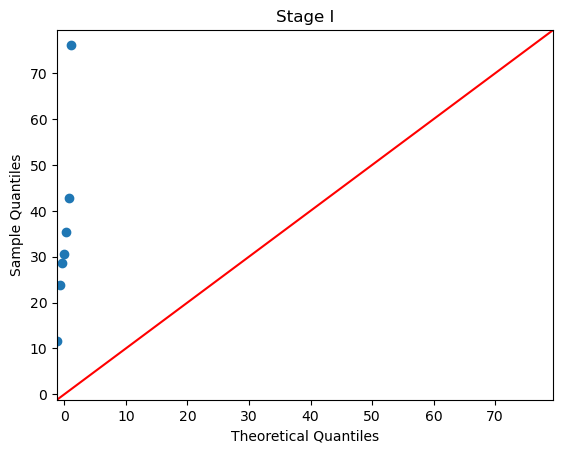

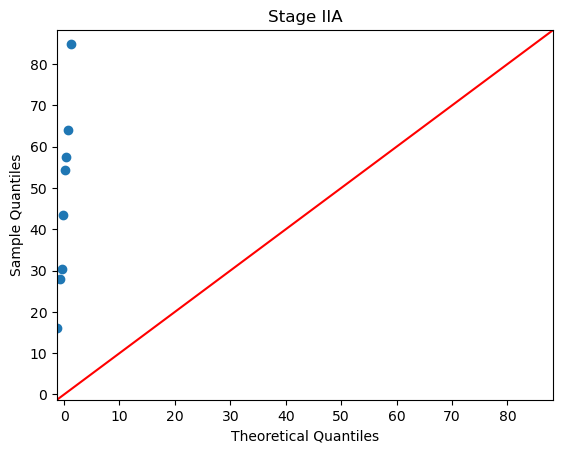

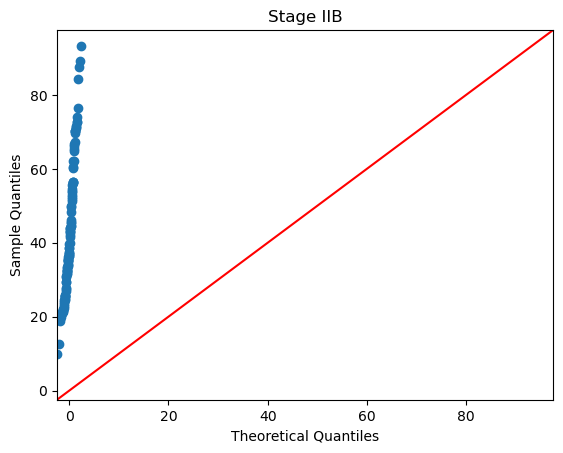

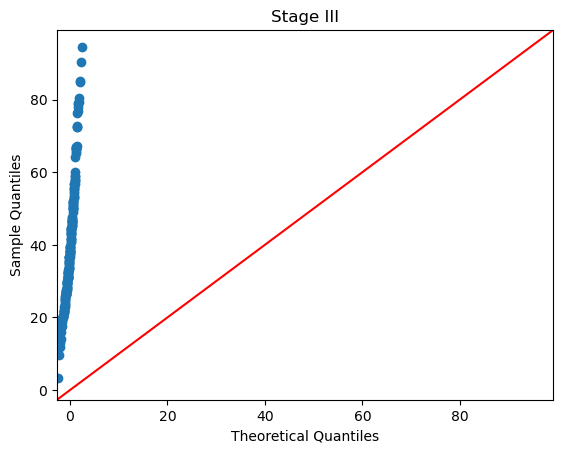

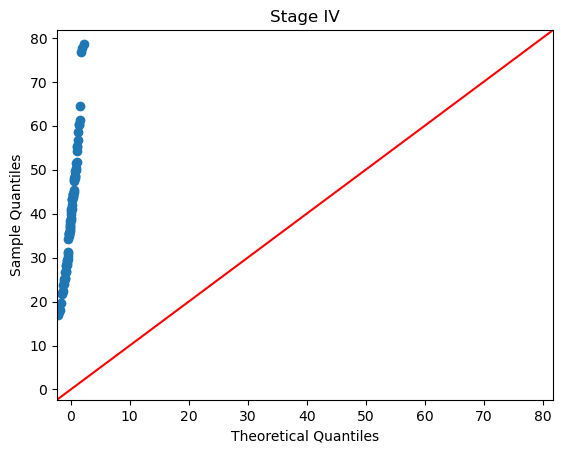

In [30]:
#Q-Q plots to check if MATH scores are are normally distributed. They are not.
for i in stages:
    sm.qqplot(stages[i], line='45')
    n = 'Stage'+' '+i
    plt.title(n)
plt.show

<Axes: xlabel='MATH', ylabel='Stage'>

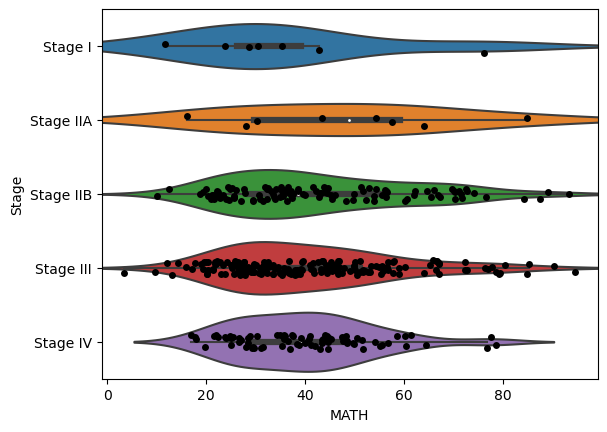

In [31]:
#alternative methods visualizing non standard distribution
sns.violinplot(data=PRAD_sort, x='MATH', y='Stage')
sns.stripplot(data=PRAD_sort, x='MATH', y='Stage', color='black')

In [32]:
#computes kendall's p-value between the MATHs of each cancer stage. Not the best method since they are not totally 
#independant
kendall = pd.DataFrame()
for i in stages:
    n = stages[i]
    for j in stages:
        k = stages[j]
        l = stats.ranksums(n,k)
        g = i+'_'+j
        kendall[g] = l

## PRAD visualization

[(0.0, 120.0)]

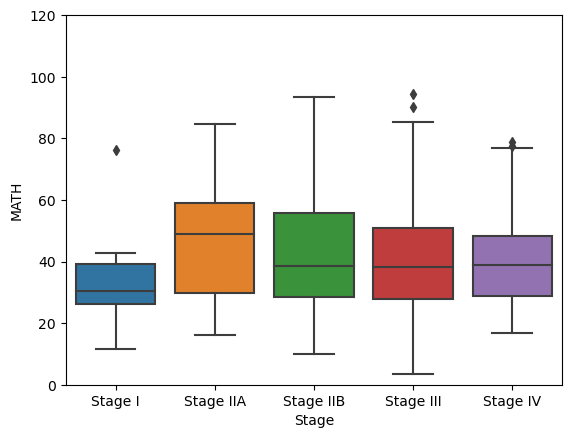

In [33]:
#simple boxplot visualization of MATH score of each cancer stage
ax = sns.boxplot(PRAD_sort, x='Stage',y='MATH')
ax.set(ylim=(0, 120))